# 1) Install the required Libraries

In [ ]:
! pip install requests pandas anndata matplotlib seaborn scipy 

# 2) Download the Dataset

In [ ]:
import os
import requests

url     = "https://figshare.com/ndownloader/files/27686835"
outfile = "human_cd34_bone_marrow.h5ad"

if not os.path.exists(outfile):
    print(f"Downloading {outfile} …")
    with requests.get(url, stream=True) as r:
        r.raise_for_status()
        with open(outfile, "wb") as f:
            for chunk in r.iter_content(8192):
                f.write(chunk)
    print("Download complete.")
else:
    print(f"{outfile} already exists, skipping download.")


# 3) R-code execution

In [ ]:
import subprocess
subprocess.run(["Rscript", "run_azimuth.r"], check=True)

# 4) Assembling the annotated file

In [ ]:
import anndata as an
import pandas as pd
from scipy import io

# read the fragments
counts  = io.mmread("counts.mtx").T.tocsr()
norm    = io.mmread("data.mtx").T.tocsr()
barcodes = pd.read_csv("barcodes.tsv", header=None)[0].astype(str).tolist()
genes    = pd.read_csv("genes.tsv",    header=None)[0].astype(str).tolist()
meta     = pd.read_csv("meta.csv", index_col=0)

# build AnnData
adata = an.AnnData(
    X      = norm,                 
    obs    = meta,
    var    = pd.DataFrame(index=genes),
    layers = {"counts": counts}    
)
adata.obs_names = barcodes
adata.var_names = genes

# write h5ad
adata.write_h5ad("annotated_expr.h5ad")

# 5) Reading the annotated file, and analyzing data

## 5.1) Number of cells per cel type

In [30]:
import anndata as ad
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.simplefilter("ignore", FutureWarning)
warnings.simplefilter("ignore", UserWarning)


# Load data
adata = ad.read_h5ad("annotated_expr.h5ad")


celltype_col = 'predicted.celltype.l2'
ct_counts = adata.obs[celltype_col].value_counts()  

print(ct_counts)

predicted.celltype.l2
LMPP              1138
GMP               1065
HSC               1028
Early Eryth        849
CLP                470
pre B              422
Late Eryth         214
pre-pDC            152
EMP                141
transitional B      82
pDC                 68
Prog Mk             60
pro B               38
BaEoMa              18
pre-mDC             14
CD4 Memory           8
cDC2                 6
ASDC                 5
Stromal              1
MAIT                 1
Name: count, dtype: int64


## 5.2) Plotting the distribution 

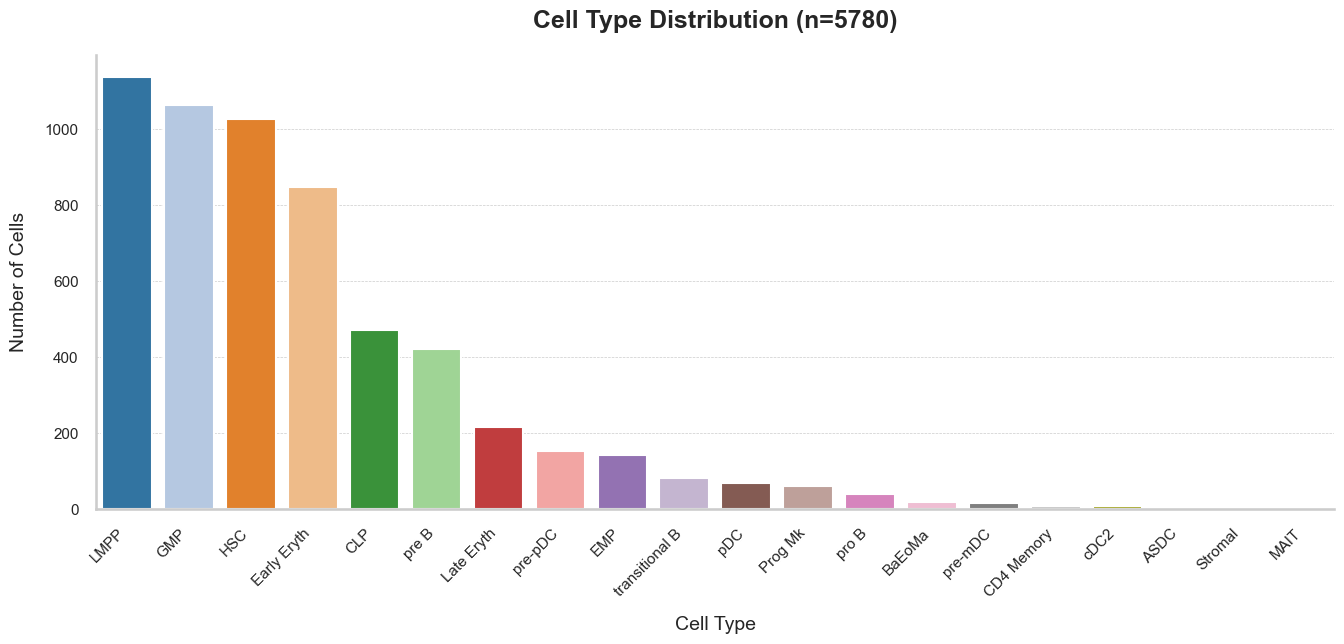

In [31]:
df = pd.DataFrame({
    'Cell Type': ct_counts.index,
    'Number of Cells': ct_counts.values
})


order = df['Cell Type'].tolist()

# Set seaborn style
sns.set(style='whitegrid', context='talk', font_scale=1.4)

plt.figure(figsize=(14, 7))
barplot = sns.barplot(
    x='Cell Type',
    y='Number of Cells',
    data=df,
    order=order,               
    palette='tab20',
    width=0.8
)

# Customize chart
barplot.set_title(f'Cell Type Distribution (n={adata.n_obs})', fontsize=18, weight='bold', pad=20)
barplot.set_xlabel('Cell Type', fontsize=14, labelpad=12)
barplot.set_ylabel('Number of Cells', fontsize=14, labelpad=12)
barplot.set_xticklabels(barplot.get_xticklabels(), rotation=45, ha='right')
barplot.tick_params(axis='x', labelsize=11)
barplot.tick_params(axis='y', labelsize=11)

sns.despine()
plt.grid(axis='y', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()